In [1]:
import sys
sys.path.insert(0, '/nfs/nfs2/users/riadoshi/bigvision_palivla/src/')
sys.path.insert(0,'/nfs/nfs2/users/riadoshi/bigvision_palivla/dlimp')
sys.path.insert(0,'/nfs/nfs2/users/riadoshi/bigvision_palivla/')

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import tensorflow as tf
tf.config.set_visible_devices([], "GPU")

import jax
import jax.experimental.multihost_utils as mhu
from jax.experimental import multihost_utils

from absl import flags
import optax
import numpy as np
import orbax.checkpoint as ocp
from transformers import AutoTokenizer
import mediapy
from ml_collections import config_flags
from typing import Any

from scalax.sharding import MeshShardingHelper, FSDPShardingRule

from palivla.components.train_state import ShardingMetadata
from palivla.model_components import ModelComponents
from palivla.dataset import make_trajectory_dataset

from scripts.train import create_model

from big_vision.utils import Registry

from octo.data.oxe import make_oxe_dataset_kwargs
from octo.data.dataset import make_single_dataset

2025-01-28 07:51:07.969470: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 07:51:07.973163: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 07:51:07.986429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738050668.008601  124952 cuda_dnn.cc:8501] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738050668.015389  124952 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 07:51:08.036607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

2025-01-28 07:51:13.159054: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/nfs/nfs2/users/riadoshi/bigvision_palivla/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reset flags if the cell is re-run
try:
    flags.FLAGS.unparse_flags()
except AttributeError:
    flags.FLAGS._flag_values_dict.clear()

# Define the config flag only if it hasn't been defined
if "config" not in flags.FLAGS:
    config_flags.DEFINE_config_file(
        "config", "/nfs/nfs2/users/riadoshi/bigvision_palivla/configs/cot_bridge_config.py", "Path to the config file."
    )

import sys
flags.FLAGS(sys.argv, known_only=True)

config = flags.FLAGS.config

In [6]:

MODEL_PATH, MODEL_STEP = 'gs://kyle-checkpoints-c2/paligemma-checkpoints/stellar-meadow-22', 50000

mesh = MeshShardingHelper([-1], ["fsdp"])
sharding_metadata = ShardingMetadata(
    mesh=mesh,
    model_sharding_rule=FSDPShardingRule(
        "fsdp", fsdp_axis_size=mesh.mesh.shape["fsdp"]
    ),
)

optimizer = optax.identity()
print("Loading model params...")

model = create_model(config, sharding_metadata)
for load_fn, load_fn_kwargs in config.load_fns:
    load_fn = Registry.lookup(load_fn)
    load_fn(model, **load_fn_kwargs)

restore_manager = ocp.CheckpointManager(
    MODEL_PATH, options=ocp.CheckpointManagerOptions()
)
model.load_state(MODEL_STEP, restore_manager)
train_state = model.train_state

Loading model params...
Replacing param /llm/embedder/input_embedding with subarray strategy


I0128 07:54:26.137517  127422 google_auth_provider.cc:181] Running on GCE, using service account 180902422847-compute@developer.gserviceaccount.com


In [7]:
viz_kwargs = config.visualization_datasets['bridge'].to_dict()
viz_kwargs['data_dir'] = 'gs://rail-orca-central2/resize_256_256/'
viz_kwargs['use_cot'] = False
viz_dataset_iterator =  make_trajectory_dataset(**viz_kwargs,
                                                train=False
).iterator()

viz_trajectories = [next(viz_dataset_iterator) for _ in range(25)]

Cause: Unable to locate the source code of <function _gcd_import at 0x7fed8e707400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7fed8e707400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7fed8e707400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/nfs/nfs2/users/riadoshi/bigvision_palivla/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/interleave_op.py:44: UserWarning: The `deterministic` argument has no effect unless the `num_parallel_calls` argument is specified.
  warnings.warn("The `deterministic` argument has no effect unless the "
2025-01-28 07:54:53.470860: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [8]:
from palivla.visualizations.chain_of_thought import parse_cot_string, visualize_trajectory, TrajectoryData
import matplotlib.pyplot as plt
import io
from PIL import Image


def create_viz(
    image: np.ndarray,
    pred_trajectory: TrajectoryData,
    target_trajectory: TrajectoryData,
    prompt_str: str,
) -> np.ndarray:
    """Create a side-by-side visualization comparing predicted and target trajectories.

    Args:
        image: Input image to show in both panels
        pred_trajectory: Predicted trajectory from the model
        target_trajectory: Target/ground truth trajectory
        prompt_str: Text prompt to show as subtitle

    Returns:
        PIL Image containing the rendered figure
    """
    # Create figure with two subplots side by side
    fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

    # Remove <pad> from prompt string
    prompt_str = prompt_str.replace("<pad>", "")
    fig.suptitle(prompt_str, wrap=True)

    # Plot predicted and target trajectories
    visualize_trajectory(ax1, image, pred_trajectory, "Predicted")

    # Adjust layout and convert to image
    plt.tight_layout()

    # Convert figure to PIL Image
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    img = Image.open(buf)
    plt.close(fig)

    return img

def chain_of_thought(model, trajectory):
    frame = jax.tree_map(lambda x: x[:1], trajectory)
    frame["observation"] = jax.tree_map(lambda x: x[None], frame["observation"])
    frame["action"] = trajectory["action"][None, :1, :]

    # Predict chain-of-thought
    sequences = model.build_sequence(frame, begin_is_prompt=True)
    viz_batch, sequences = mhu.broadcast_one_to_all(
        ({"observation": frame["observation"]}, sequences)
    )
    predicted_tokens = model.predict_tokens(
        viz_batch, sequences, use_ema_params=False, replicate=True
    )

    # Decode the tokens
    predicted_text_tokens = np.array(
        [model.language_tokenizer.decode(tok) for tok in predicted_tokens[0]]
    )
    # print(predicted_text_tokens)

    prompt_tokens = sequences["prompt"]["tokens"]
    prompt_text_tokens = np.array(
        [
            model.language_tokenizer.decode(tok)
            for tok in prompt_tokens[0]
            if tok != "<pad>"
        ]
    )
    # print(prompt_text_tokens)

    # Get action start indices
    pred_action_start_idxs = (
        np.argwhere(predicted_text_tokens == "<begin_of_action>") + 1
    )
    pred_action_start_idx = (
        np.min(pred_action_start_idxs) if pred_action_start_idxs.size > 0 else -1
    )

    # Concatenate tokens into strings
    prompt_str = "".join(prompt_text_tokens)
    pred_cot_str = "".join(predicted_text_tokens[:pred_action_start_idx])

    # Parse both predicted chain of thought string
    pred_trajectory = parse_cot_string(pred_cot_str)

    # Create side-by-side visualization
    image = frame["observation"]["image_primary"].squeeze()
    comparison_image = create_viz(
        image, pred_trajectory, pred_trajectory, prompt_str
    ) # this is just gonna be predicted trajectory twice

    return comparison_image



/tmp/ipykernel_124952/3970352894.py:47: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  frame = jax.tree_map(lambda x: x[:1], trajectory)
/tmp/ipykernel_124952/3970352894.py:48: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  frame["observation"] = jax.tree_map(lambda x: x[None], frame["observation"])


(224, 224, 3)


""

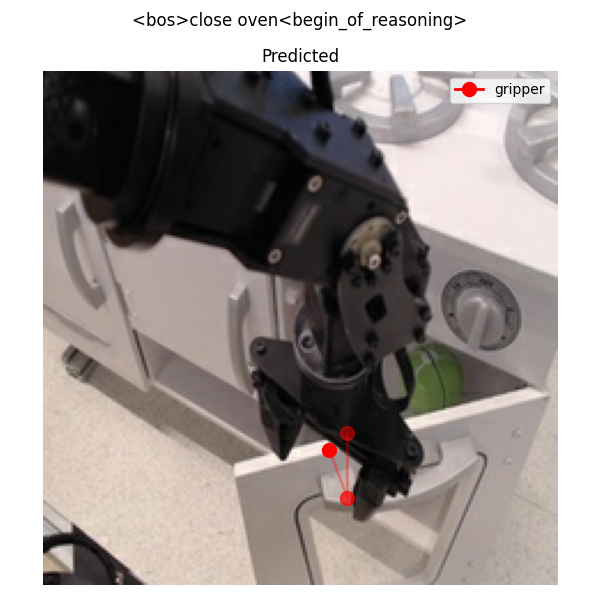

In [9]:
for i in range(1,2):
    traj = viz_trajectories[i]
    traj['reasonings'] = np.array(["" for _ in range(len(traj['action']))])

    img = chain_of_thought(model, traj)
    mediapy.show_image(img)